# 📧 Système Intelligent de Filtrage des Emails (Spam vs Ham)

Ce projet vise à développer un système intelligent capable de filtrer les emails en détectant s’ils sont des spams ou non (ham), en utilisant des techniques de traitement automatique du langage (NLP) et de classification supervisée.


## 📦 1. Importation des bibliothèques

Dans cette section, nous importons toutes les bibliothèques nécessaires au projet : traitement des données, visualisations, NLP, Machine Learning et sauvegarde de modèles. Ces outils vont nous permettre de structurer le pipeline de classification d’emails de manière rigoureuse et efficace.



In [2]:
# ===============================
# 1. 📦 Importation des bibliothèques
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import joblib



## 📥 2. Chargement et nettoyage des données

Nous chargeons le jeu de données contenant les emails et leurs étiquettes (spam ou ham), puis procédons à un nettoyage de base :
- Vérification des colonnes
- Suppression des doublons
- Suppression des valeurs manquantes

Cela permet de garantir la qualité des données avant toute analyse ou modélisation.


In [3]:
# ===============================
# 2. 📥 Chargement & Nettoyage des données
# ===============================
df = pd.read_csv("../data/DataSet_Emails.csv")
# delete duplicated lines

print("Initial shape of the dataset:", df.shape)
print("nb de lighne dup", df.duplicated().sum())
df.drop_duplicates(inplace=True)
# Drop rows with NaN 
nb= df.shape[0]
print("le nb du nan", df.isnull().sum().sum())
df.dropna(inplace=True)
print("lignes supprimer :", nb-df.shape[0])

Initial shape of the dataset: (31716, 8)
nb de lighne dup 0
le nb du nan 670
lignes supprimer : 568



---

## 📊 3. Analyse exploratoire des données (EDA)

L’EDA permet de comprendre la structure du jeu de données :
- Dimensions, types, aperçu des premières lignes
- Répartition des classes (spam vs ham)
- Analyse visuelle à travers des nuages de mots pour identifier les termes fréquents dans chaque type d’email

Cette étape est cruciale pour orienter les choix de modélisation.


In [4]:
# ===============================
# 3. 📊 Analyse exploratoire (EDA)
# ===============================
# dimensions et aperçu des données
print("Dimensions:", df.shape)

df.head()


Dimensions: (31148, 8)


,Unnamed: 0,message_id,text,label,label_text,subject,message,date
0,0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


Distribution des emails:
 label_text
spam    15645
ham     15503
Name: count, dtype: int64


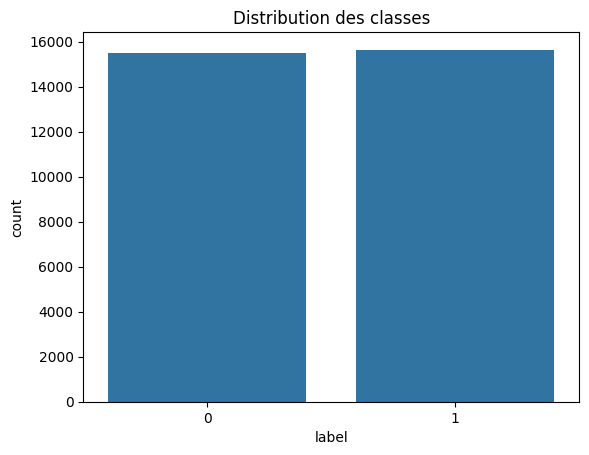

In [5]:
nb= df['label_text'].value_counts()
print("Distribution des emails:\n", nb)
# distribution des classes
sns.countplot(x='label', data=df)
plt.title("Distribution des classes")
plt.show()


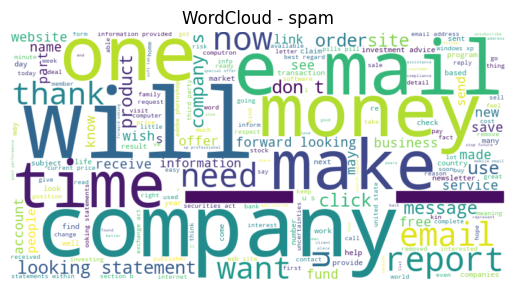

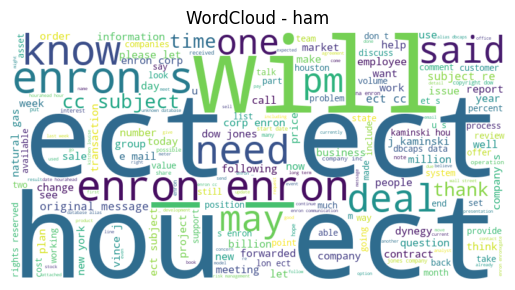

In [6]:

# ===============================
# generation des nuages de mots
# ===============================
def generate_wordcloud(data, label):
    text = " ".join(data[data['label_text'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label}")
    plt.show()
generate_wordcloud(df, 'spam')
generate_wordcloud(df, 'ham')


---

## 🧽 4. Prétraitement des textes (NLP)

Avant de vectoriser les emails, nous appliquons plusieurs transformations textuelles :
- Conversion en minuscules
- Tokenisation
- Suppression des stopwords, de la ponctuation et des caractères spéciaux
- Stemming (réduction à la racine des mots)

Ces étapes permettent de normaliser le texte et d'améliorer la qualité de la représentation vectorielle.


In [7]:
# ===============================
# 4. 🧽 Prétraitement du texte (NLP)
# ===============================
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)
df.dropna()
df.drop_duplicates()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,message_id,text,label,label_text,subject,message,date,clean_text
0,0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18,softwar 15 99 understand oem softwar lead temp...
1,1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19,perspect ferc regulatori action client conf ca...
2,2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11,want tri ci 4 li thought way expens viagra 1 1...
3,3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12,enron hpl actual decemb 11 2000 teco tap 30 00...
4,4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13,look cheap high qualiti softwar rotat napoleon...
...,...,...,...,...,...,...,...,...,...
31711,31711,14628,"credit netco start up plan louise ,\nattached ...",0,ham,credit netco start up plan,"louise ,\nattached is the electronic version o...",2002-01-07,credit netco start plan louis attach electron ...
31712,31712,16049,"everything you are looking for hello , visit o...",1,spam,everything you are looking for,"hello , visit our amazing\nonline shop !\nnows...",2005-03-26,everyth look hello visit amaz onlin shop nowsp...
31713,31713,18024,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,start date : 2 / 5 / 02 ; hourahead hour : 18 ;,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,2002-02-05,start date 2 5 02 hourahead hour 18 start date...
31714,31714,1639,corhshucker daren - - - -\nthe invoices are be...,0,ham,corhshucker,daren - - - -\nthe invoices are being paid by ...,2000-09-19,corhshuck daren invoic paid us jame armstrong ...



---

## 🔢 5. Extraction des caractéristiques

Nous utilisons la méthode TF-IDF (Term Frequency-Inverse Document Frequency) pour convertir les textes en vecteurs numériques exploitables par les modèles de Machine Learning.

Nous séparons ensuite les données en variables explicatives `X` et variable cible `y`, puis divisons le jeu de données en ensemble d'entraînement et de test.


In [8]:
# ===============================
# 5. 🔢 Extraction des caractéristiques
# ===============================
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



---

## 🤖 6. Entraînement de plusieurs modèles

Nous testons différents algorithmes de classification supervisée :
- Naive Bayes
- Arbre de Décision (Decision Tree)
- SVM (Support Vector Machine)

Le but est de comparer leurs performances afin de sélectionner le plus performant.


In [9]:
# ===============================
# 6. 🤖 Entraînement de plusieurs modèles
# ===============================
models = {
    'NaiveBayes': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'DecisionTree': DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))



NaiveBayes Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3032
           1       0.99      0.99      0.99      3198

    accuracy                           0.99      6230
   macro avg       0.99      0.99      0.99      6230
weighted avg       0.99      0.99      0.99      6230


SVM Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3032
           1       0.99      1.00      0.99      3198

    accuracy                           0.99      6230
   macro avg       0.99      0.99      0.99      6230
weighted avg       0.99      0.99      0.99      6230


SVM Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3032
           1       0.99      1.00      0.99      3198

    accuracy                           0.99      6230
   macro avg       0.99      0.99      0.99      6230
weighted avg       0.99  


---

## 📈 7. Évaluation des modèles

À l’aide de métriques standards :
- Matrice de confusion
- Précision
- Rappel
- F1-score

Nous évaluons la qualité de chaque modèle sur le jeu de test, afin d’avoir une vision claire de leurs performances respectives.



---

## 🔁 8. Validation croisée (Cross-validation)

Pour renforcer la robustesse de l’évaluation, nous utilisons une validation croisée à 5 plis. Cela permet de tester le modèle sur différentes sous-parties du dataset et de vérifier sa stabilité.


In [10]:
# ===============================
# 8. 🔁 Validation croisée
# ===============================
from sklearn.model_selection import cross_val_score
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train , cv=5 , scoring='f1')
    print(f"{name }: f1 score = {scores.mean():.3f} (+/- {scores.std():.3f})")


NaiveBayes: f1 score = 0.986 (+/- 0.002)
SVM: f1 score = 0.991 (+/- 0.001)
SVM: f1 score = 0.991 (+/- 0.001)
DecisionTree: f1 score = 0.960 (+/- 0.003)
DecisionTree: f1 score = 0.960 (+/- 0.003)



---

## 🔧 9. Optimisation des hyperparamètres

Nous utilisons `GridSearchCV` pour optimiser les paramètres du modèle SVM. Cette méthode permet de tester plusieurs combinaisons de paramètres pour identifier celle qui donne les meilleurs résultats.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define your parameter distributions
param_dist = {
    'C': [0.1, 1, 10],                     # or use continuous: e.g. uniform(0.1, 10)
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.001]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=6,           # number of random combinations to try
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best SVM Parameters:", random_search.best_params_)
print("Best Cross‑Val Score:", random_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best SVM Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 1}
Best Cross‑Val Score: 0.9910506234842122
Best SVM Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 1}
Best Cross‑Val Score: 0.9910506234842122



---

## 💾 10. Sauvegarde du meilleur modèle

Le meilleur modèle et le vectoriseur TF-IDF sont sauvegardés avec `joblib`, afin de pouvoir être réutilisés dans une application (Streamlit par exemple) sans devoir les réentraîner.


In [15]:
# ===============================
# 10. 💾 Sauvegarde du meilleur modèle
# ===============================
best_model = random_search.best_estimator_
joblib.dump(best_model, '../models/model.pkl')
joblib.dump(vectorizer, '../models/vectorizer.pkl')

['../models/vectorizer.pkl']


---

## 🌐 11. Interface utilisateur avec Streamlit

Nous créerons une interface simple avec Streamlit permettant à l'utilisateur d’entrer un texte d’email et d’obtenir en retour une prédiction :
- Zone de saisie de texte
- Bouton "Analyser"
- Affichage clair : Spam ou Ham
- (Optionnel) Affichage de la probabilité

Cette interface permettra une utilisation interactive du modèle en production.

